## Análisis de regionalismos

En esta notebook haremos un análisis de regionalismos. Para ello, utilizaremos [Diccionario Argentino](https://www.diccionarioargentino.com/terms/p) para obtener una lista de expresiones y palabras regionales.

Preproceso un poco el slang

In [10]:
%load_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd

regionalism_csv = []
for csv_path in glob("../data/regionalisms/test_*.csv"):
    regionalism_csv.append(pd.read_csv(csv_path, index_col=0))

df_regionalism = pd.concat(regionalism_csv)

# Drop columns except title, text, context_tweet, prompt, pred_cot
df_regionalism = df_regionalism[["title", "text", "context_tweet", "prompt", "pred_cot"]].copy()

df_regionalism.sample(10)

,title,text,context_tweet,prompt,pred_cot
id,,,,,
349719,"Graciana Peñafort: ""La marcha me dio mucha pena y tuvo un nivel de convocatoria menor al esperado""",@usuario 🤣🤣🤣,Graciana Peñafort: “La marcha me dio mucha pena y tuvo un nivel de convocatoria menor al esperado” https://t.co/sPiBqGmFIg,"Explicar si existe un término o expresión regional del español de Argentina en el texto a continuación. Un regionalismo es una expresión de carácter usualmente coloquial usada en alguna variedad dialectal del español. No consideramos nombres propios (personas, lugares, etc) como tales. La expresión regional puede estar en el contexto (titular de noticia) o en el comentario. Razonar paso a paso antes de dar la respuesta.\n###\ncontexto: ¿More Rial cuestionó las habilidades de su ex en la cama?Luego de su separación con Facundo Ambrosioni, la mediática hizo una fuerte referencia a su vida sexual\nrespuesta: La expresión ""acumulando mas leche"" es de carácter regional, y se refiere a la acumulación de deseos sexuales. La respuesta final es sí.\n###\ncontexto: Enrique Pinti no descarta una nueva postulación de Macri: “En este país siempre hay una chance para cualquiera que nos vuelva a cagar”\nrespuesta: La expresión ""trolo"" es un término regional en Argentina usado para referirse a una...","La expresión ""🤣🤣🤣"" es un emoji que no constituye un término regional del español de Argentina. La respuesta final es no."
336555,Detuvieron a otro delincuente recientemente liberado por la excusa del coronavirus: volvió a golpear a su familia,@usuario ¿Ya echaron al juez con juicio político?,Detuvieron a un delincuente recientemente liberado por la excusa del coronavirus: volvió a golpear a su familia https://t.co/kRHjqDIljH,"Explicar si existe un término o expresión regional del español de Argentina en el texto a continuación. Un regionalismo es una expresión de carácter usualmente coloquial usada en alguna variedad dialectal del español. No consideramos nombres propios (personas, lugares, etc) como tales. La expresión regional puede estar en el contexto (titular de noticia) o en el comentario. Razonar paso a paso antes de dar la respuesta.\n###\ncontexto: ¿More Rial cuestionó las habilidades de su ex en la cama?Luego de su separación con Facundo Ambrosioni, la mediática hizo una fuerte referencia a su vida sexual\nrespuesta: La expresión ""acumulando mas leche"" es de carácter regional, y se refiere a la acumulación de deseos sexuales. La respuesta final es sí.\n###\ncontexto: Enrique Pinti no descarta una nueva postulación de Macri: “En este país siempre hay una chance para cualquiera que nos vuelva a cagar”\nrespuesta: La expresión ""trolo"" es un término regional en Argentina usado para referirse a una...","La expresión ""Ya echaron al juez con juicio político"" no contiene expresiones regionales. La respuesta final es no."
342464,"Coronavirus: Ginés Gonzalez García se comparó con China y Europa y aseguró que ""hoy se habla del modelo argentino""","@usuario @usuario por favor los compañeros taxistas se están muriendo de hambre.Te ruego AYUDA.Están la gran mayoría en categoría C, D y E. No trabajan no entra plata no hay para comprar comida ni para darle de comer a los hijos.Estamos todos desesperados. Y son los q mas aportan al País","Coronavirus: Ginés Gonzalez García se comparó con China y Europa y aseguró que ""hoy se habla del modelo argentino"" https://t.co/jQUyxLSN5X","Explicar si existe un término o expresión regional del español de Argentina en el texto a continuación. Un regionalismo es una expresión de carácter usualmente coloquial usada en alguna variedad dialectal del español. No consideramos nombres propios (personas, lugares, etc) como tales. La expresión regional puede estar en el contexto (titular de noticia) o en el comentario. Razonar paso a paso antes de dar la respuesta.\n###\ncontexto: ¿More Rial cuestionó las habilidades de su ex en la cama?Luego de su separación con Facundo Ambrosioni, la mediática hizo una fuerte refere

In [19]:
from rioplatense_hs.preprocessing import remove_accents
from rioplatense_hs.regionalisms import find_slangs
import re
from tqdm import tqdm

# Regex para buscar todas las palabras entre comillas

def find_between_quotes(text):
    return re.findall(r'"([^"]*)"', text)


def get_regionalisms(row):
    text = remove_accents(row["pred_cot"].lower())

    # Si dice "la respuesta final es si", buscar todas las ocurrencias entre comillas
    if "respuesta final es si" in text:
        return find_between_quotes(text)
    else:
        return []

tqdm.pandas()

df_regionalism["gpt_regionalisms"] = df_regionalism.apply(get_regionalisms, axis=1)
df_regionalism["dict_regionalisms"] = df_regionalism.progress_apply(lambda x: find_slangs(x["text"]), axis=1)

100%|██████████| 5670/5670 [15:16<00:00,  6.18it/s]


In [23]:
del df_regionalism["prompt"]

In [24]:
df_regionalism.to_csv("../data/regionalisms/df_regionalism.csv")

¿Cuántos marcó diccionario y cuantos gpt?

In [28]:
(df_regionalism["gpt_regionalisms"].apply(len) > 0).value_counts()

gpt_regionalisms
False    3058
True     2612
Name: count, dtype: int64

In [29]:
(df_regionalism["dict_regionalisms"].apply(len) > 0).value_counts()

dict_regionalisms
False    3375
True     2295
Name: count, dtype: int64

In [30]:
df_regionalism["has_regionalisms"] = (df_regionalism["gpt_regionalisms"].apply(len) > 0) | (df_regionalism["dict_regionalisms"].apply(len) > 0)

df_regionalism["has_regionalisms"].value_counts()


has_regionalisms
True     3412
False    2258
Name: count, dtype: int64

In [31]:
df_regionalism[df_regionalism["has_regionalisms"]].to_csv("../data/regionalisms/check_regionalisms.csv")

### Resultados ya anotados

In [84]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_regionalism = pd.read_csv("../data/regionalisms/check_regionalisms_annotated.csv", index_col=0)

df_regionalism = df_regionalism.rename(columns={"CHECK": "is_regional"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nos quedamos con los índices de los tweets que tengan slang.



In [85]:
indices = df_regionalism[df_regionalism["is_regional"] > 0].index

len(indices)

1547

In [87]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/test*pred*12shot.csv")),
    "beto": sorted(glob("../data/test*beto.csv")),
    "aya": sorted(glob("../data/test*aya_.csv")),
    "mixtral": sorted(glob("../data/test*mixtral.csv")),
}

assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}

# Me quedo sólo con los que tienen regionalismos

dfs_regional = {k: v[v.index.isin(indices)] for k, v in dfs.items()}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
dfs["beto"][all_labels].mean()

WOMEN        0.0231
LGBTI        0.0155
RACISM       0.0406
CLASS        0.0134
POLITICS     0.0254
DISABLED     0.0116
APPEARANCE   0.0333
CRIMINAL     0.0326
dtype: float64

In [93]:
dfs_regional["beto"][all_labels].mean()

WOMEN        0.0524
LGBTI        0.0220
RACISM       0.0491
CLASS        0.0349
POLITICS     0.0666
DISABLED     0.0226
APPEARANCE   0.0595
CRIMINAL     0.0323
dtype: float64

Chequear que tengan todas la misma long

In [25]:
{key: len(value) for key, value in dfs.items()}

{'gpt-3.5': 1547, 'beto': 1547, 'aya': 1547, 'mixtral': 1547}

In [27]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [28]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]

model_order = ["aya", "gpt-3.5", "mixtral", "beto"]
pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

In [36]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score, num_bootstraps=150)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


gpt-3.5


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

aya


  0%|          | 0/4 [00:00<?, ?it/s]

mixtral


  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,gpt-3.5,WOMEN,f1,0.3768
1,gpt-3.5,WOMEN,f1,0.4568
2,gpt-3.5,WOMEN,f1,0.3671
3,gpt-3.5,WOMEN,f1,0.4342
4,gpt-3.5,WOMEN,f1,0.4258
...,...,...,...,...
7195,mixtral,CLASS,precision,0.2906
7196,mixtral,CLASS,precision,0.2791
7197,mixtral,CLASS,precision,0.2764
7198,mixtral,CLASS,precision,0.2130


In [38]:
pd.options.display.float_format = "{:.4f}".format

pd.options.display.max_rows = 100


f1s = df_metrics[df_metrics["metric"] == "f1"]


f1s.groupby(["model", "label", "metric"]).agg(["mean", "std"])

score       
                        mean    std
model   label  metric              
aya     CLASS  f1     0.2003 0.0310
        LGBTI  f1     0.2533 0.0528
        RACISM f1     0.4593 0.0408
        WOMEN  f1     0.2579 0.0338
beto    CLASS  f1     0.6732 0.0619
        LGBTI  f1     0.4722 0.0801
        RACISM f1     0.7012 0.0479
        WOMEN  f1     0.5108 0.0552
gpt-3.5 CLASS  f1     0.4739 0.0583
        LGBTI  f1     0.4887 0.0755
        RACISM f1     0.6400 0.0428
        WOMEN  f1     0.4086 0.0532
mixtral CLASS  f1     0.3602 0.0460
        LGBTI  f1     0.4930 0.0619
        RACISM f1     0.6091 0.0400
        WOMEN  f1     0.3682 0.0460

In [62]:
full_results = pd.read_csv("../results/full_results.csv", index_col=0)


diff = df_metrics.groupby(["model", "label", "metric"]).agg("mean") - full_results.groupby(["model", "label", "metric"]).agg("mean")

diff = diff.reset_index()

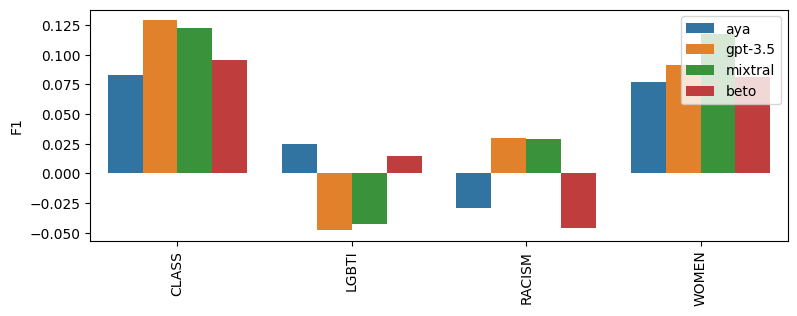

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(df, metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "f1"
plot_metric(diff, metric, all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

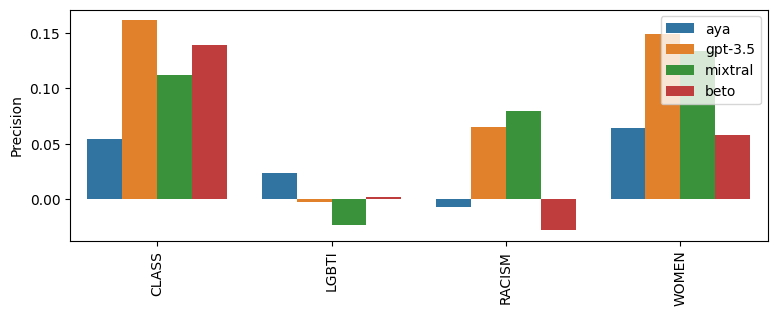

In [64]:
plot_metric(diff, "precision", all_labels)

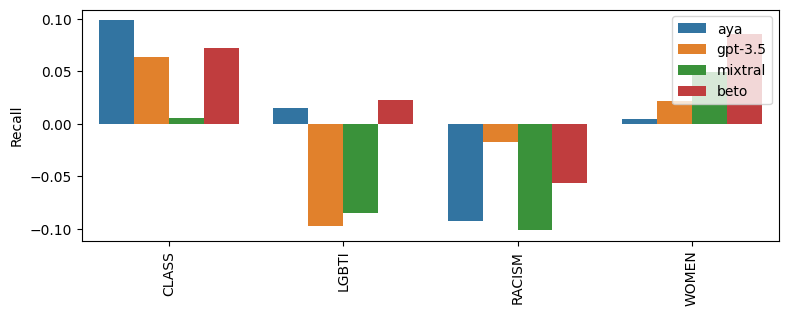

In [66]:
plot_metric(diff, "recall", all_labels)

¿Qué pasa que mejora tanto todo en CLASE?

In [80]:
df_beto = dfs["beto"]

df_beto["HATEFUL"].mean()

0.24628312863606983

In [83]:
df_beto[all_labels].sum()

WOMEN          81
LGBTI          34
RACISM         76
CLASS          54
POLITICS      103
DISABLED       35
APPEARANCE     92
CRIMINAL       50
dtype: int64

Ok! Hay muchos más odio en este conjunto de datos (cerca de 1 sobre 4) vs 1 sobre 7 en el conjunto en general

Ok, acá vemos lo siguiente:

- En CLASE, los 

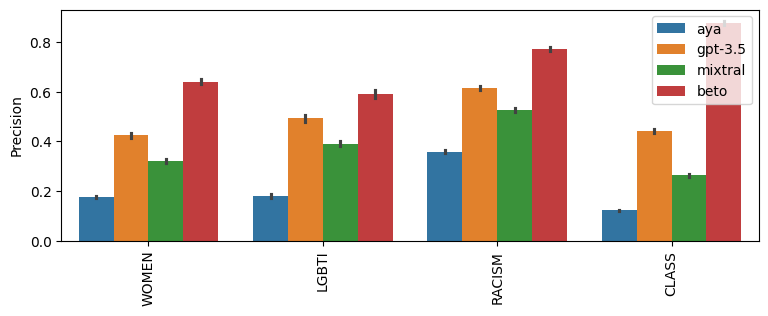

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df_metrics[(df_metrics["metric"] == metric) & (df_metrics["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(metric, all_labels)
#lt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

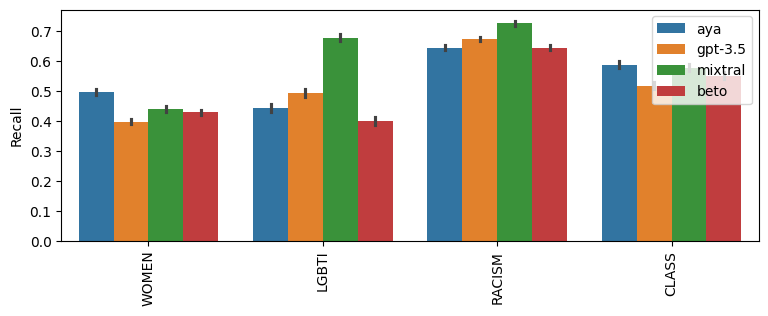

In [40]:
plot_metric("recall", all_labels)
#plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

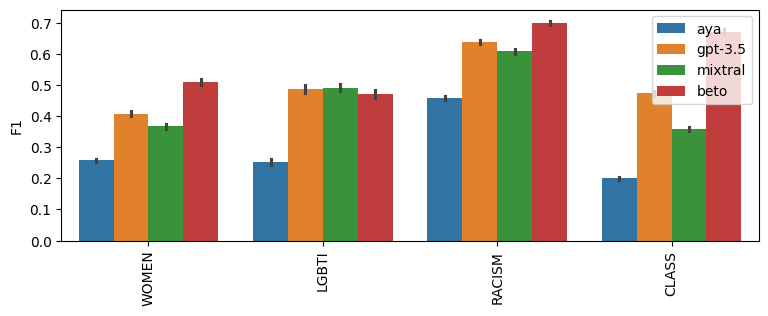

In [42]:
plot_metric("f1", all_labels)
#plt.savefig(f"img/f1.png", bbox_inches='tight', dpi=300)

In [45]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,f1,0.5618
1,gpt-3.5,f1,0.5519
2,gpt-3.5,f1,0.5451
3,gpt-3.5,f1,0.5702
4,gpt-3.5,f1,0.5621
...,...,...,...
1795,mixtral,precision,0.3636
1796,mixtral,precision,0.3753
1797,mixtral,precision,0.3702
1798,mixtral,precision,0.3315


([0, 1, 2], [Text(0, 0, 'f1'), Text(1, 0, 'recall'), Text(2, 0, 'precision')])

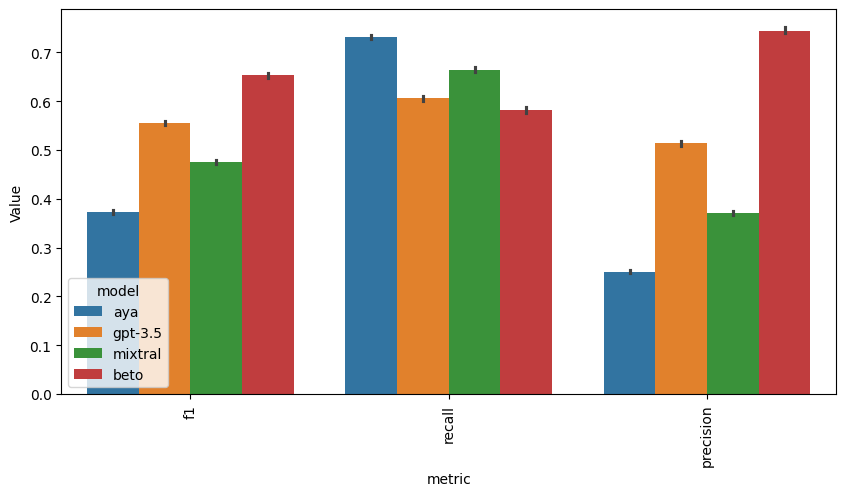

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()